<a href="https://colab.research.google.com/github/RN0311/Classifying-Songs-Genre/blob/main/Classiying_Song_Genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step1: 
## **Inspiration**
### *Many streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics.Let's look through a dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression*

In [21]:
#Importing the libraries
import pandas as pd

# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Import numpy
import numpy as np

# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression



In [22]:
# Read in track metadata with genre labels
tracks = pd.read_csv('/content/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('/content/echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


# Step2: 
## ***Finding pairwise relationships between continuous variabless***

### Since we want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy / finding pairwise relationship:
### *1. To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).*
### *2. When the dataset is very large, using fewer features can drastically speed up our computation time.*

In [23]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


# Step3:
## **Normalizing the feature data**

### *It can be particularly useful to simplify the models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).*

### *It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.*

### *However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).*

In [24]:
# Define our features 
features = echo_tracks.drop(columns=['genre_top','track_id'])

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

# Step4:
## **Principle Component Analysis**

### *After preprocessing the data, need to use PCA to determine by how much we can reduce the dimensionality of the data - can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.*

### *Note: Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff*


Text(0.5, 0, 'Principal Component #')

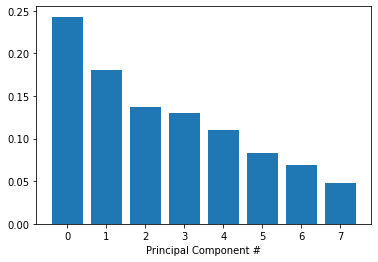

In [25]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

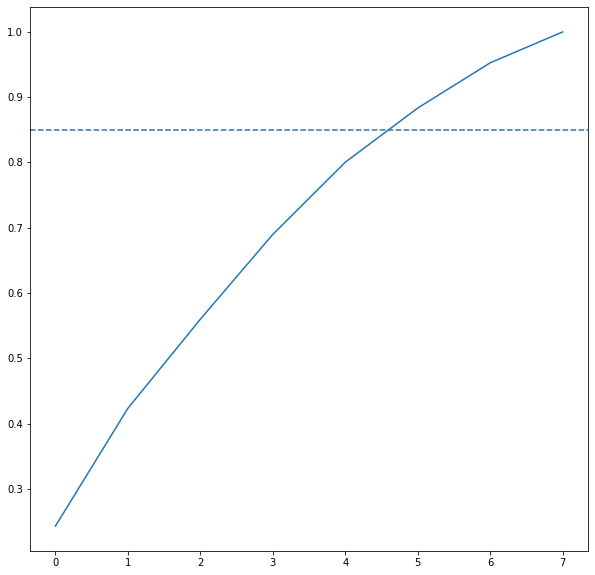

In [26]:
plt.rcParams["figure.figsize"] = (10,10)
# Calculate the cumulative explained variance
cum_exp_variance =np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## Step5:
## **Train a decision tree to classify genre**

### *Now we can use the lower dimensional PCA projection of the data to classify songs into genres. To do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.*

### *Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.*

### *Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.*



In [27]:
%%html
<iframe src="https://drive.google.com/file/d/1HDxHIVTym1LlAcuobwVc8KnCYWTQHnya/preview" width="640" height="480" allow="autoplay">
</iframe>

In [28]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

# Step6:
## Compare our decision tree to a logistic regression

### *Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.*

### *Sometimes simplest is best, and so we will start by applying logistic regression. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified).*

In [29]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201

